In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display

import Jupyter_module_loader
# from utility import *

In [3]:
# dataset_name = "W10_only"
# df_list = ["BES_reduced"]#,"BES_reduced_with_na"]#,"BESnumeric"]

In [4]:
# # you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
# encoding = "ISO-8859-1"

# (BES_code_folder, BES_small_data_files, BES_data_folder,
#  BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [5]:
# %%time
# global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
# data_subfolder = BES_data_folder + dataset_name + os.sep

# (manifest, dataset_filename, dataset_description, dataset_citation,
#  dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

# for df in df_list:
#     if df=="BES_Panel":
#         globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))

#     else:
#         globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
# #         globals()[df].replace(-1,np.nan,inplace=True)

# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

In [6]:
%%time
dataset_name = "W10_only"
df_list = "BES_Panel|BES_reduced"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')


Toggle code

var_type (354, 13)
Wall time: 1.84 s


In [7]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time

In [8]:
# warnings - don't know why, online comments suggest just blocking
tf.logging.set_verbosity(tf.logging.ERROR)

In [9]:
drop_vars = []
drop_vars.extend( [x for x in BES_reduced.columns if "eurefvote" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "euid_" in x.lower() ] )
drop_vars.extend( [x for x in BES_reduced.columns if "happyeuleave" in x.lower() ] )
drop_vars                 

['profile_eurefvote_Leave the EU',
 'euRefVote_Leave the EU',
 'euID_The leave side',
 'happyEULeave__Extremely happy']

In [10]:
# [x for x in BES_reduced.columns if "euref" in x.lower()]
y = BES_reduced['euRefVote_Leave the EU']
X = BES_reduced.drop(drop_vars,axis=1)

In [11]:
from tensorflow.python.keras.utils import to_categorical
y = to_categorical(y)

In [12]:
X.shape

(30319, 328)

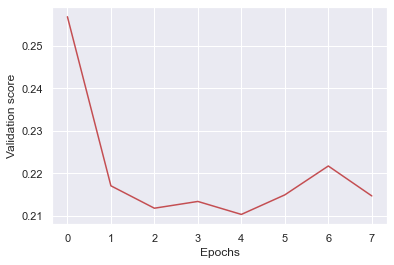

17.025551557540894


In [34]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
no_of_outputs = len(np.unique(y))
model.add( Dense( no_of_outputs , activation='softmax') )

# Compile the model
model.compile( optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X.values, y, epochs=15, validation_split=0.2, callbacks=[early_stopping_monitor], verbose=False)

# Create the plot
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [14]:
# 16s, epoch 4:.164

In [37]:
model.

[<tf.Tensor 'dense_5_input:0' shape=(?, 328) dtype=float32>]

In [14]:
import shap
# from shap.explainers.deep import DeepExplainer
# from shap.explainers.gradient import GradientExplainer
# e = DeepExplainer(model,X)

In [15]:
tf.__version__

'1.14.0'

In [17]:
## Deep learning has install issues! Going to create a new environment just for tensorflow


# meh - issue is cpu not set up to use post 1.5 special commands!

# I guess install gpu_ocelot and cuda version???
# lot of work!

In [33]:
# %%time
# from tensorflow.python.ops import gradients_impl as tf_gradients_impl
# tf_gradients_impl._IsBackpropagatable=True
# # hasattr(tf_gradients_impl, "_IsBackpropagatable")
background = X.loc[np.random.choice(X.shape[0], 200, replace=False)]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, X)
shap_values = e.shap_values(X)

ValueError: Dimension 1 in both shapes must be equal, but are 2 and 1. Shapes are [?,2] and [?,1]. for 'gradients_5/dense_4/Softmax_grad/gradients/gradients_5/dense_4/Softmax_grad/truediv_grad/Select_1' (op: 'Select') with input shapes: [?,1], [?,2], [?,2].

In [29]:
background = X.loc[np.random.choice(X.shape[0], 200, replace=False)]

# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
e = shap.DeepExplainer(model, background)


In [31]:
shap_values = e.shap_values(background)

ValueError: Dimension 1 in both shapes must be equal, but are 2 and 1. Shapes are [?,2] and [?,1]. for 'gradients_4/dense_4/Softmax_grad/gradients/gradients_4/dense_4/Softmax_grad/truediv_grad/Select_1' (op: 'Select') with input shapes: [?,1], [?,2], [?,2].

In [38]:
# this is the code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ModuleNotFoundError: No module named 'keras'

In [20]:
# 100: 1.2s
# 500: 16.4s
# 1000: 66s

# same size but larger neural net -> 7 mins

In [20]:
gc.collect()

3374

In [21]:
from tensorflow.python.ops import gradients_impl

In [22]:
shap.summary_plot(shap_values[0], background, plot_type='dot')

NameError: name 'shap_values' is not defined

In [24]:
X

,turnoutUKGeneral__Very likely that I will vote,generalElectionCertainty__Completely certain,partyIdStrength__Not very strong,expectGoodConductEURef__Conducted unfairly,polAttention__Pay a great deal of attention,britishness__Very strongly British,englishness__Very strongly English,europeanness__Very strongly European,likeMay__Strongly like,likeCorbyn__Strongly like,...,expectAccess_Yes,negotiationSpecifics_none_Yes,negotiationSpecifics_3_Yes,negotiationSpecifics_2_Yes,negotiationSpecifics_1_Yes,bestPM_Jeremy Corbyn,profile_eurefturnout_Yes,gender_Female,euRefDoOver_Yes,regretsIHaveAFewEU_Yes
0,4.0,6.0,0.0,0.0,7.0,3.0,6.0,0.0,4.0,0.0,...,0,0,1,1,1,0,1,0,0,0
1,4.0,5.0,1.0,0.0,8.0,4.0,4.0,3.0,7.0,1.0,...,0,0,1,1,1,0,1,1,0,0
2,3.0,6.0,2.0,3.0,8.0,5.0,4.0,2.0,5.0,2.0,...,0,0,1,0,1,0,1,1,0,0
3,4.0,6.0,0.0,4.0,5.0,5.0,0.0,4.0,0.0,10.0,...,0,0,1,1,1,1,1,0,1,0
4,4.0,5.0,1.0,0.0,9.0,6.0,6.0,4.0,8.0,0.0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30314,4.0,3.0,1.0,4.0,5.0,5.0,4.0,4.0,3.0,8.0,...,0,0,1,1,1,1,1,1,1,0
30315,1.0,6.0,1.0,2.0,1.0,3.0,3.0,3.0,5.0,2.0,...,0,0,1,1,1,0,1,1,0,0
30316,3.0,3.0,2.0,0.0,5.0,6.0,6.0,3.0,8.0,4.0,...,0,0,1,1,1,0,1,1,0,0
30317,3.0,6.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,6.0,...,0,0,0,0,1,1,1,0,1,0


In [25]:
### problems getting DeepExplainer to work, tried KernelExplainer ... super slow!

In [26]:
f = lambda x: model.predict_proba(x)

In [27]:
explainer = shap.KernelExplainer(f, X.values[0:-1:100,0:])

Using 304 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [28]:
# shap_values = explainer.shap_values(X[0:-1:100,0:])
# unspeakably slow!

In [29]:
gc.collect()

9346

In [30]:
import umap

ModuleNotFoundError: No module named 'umap'

In [ ]:
X.shape

In [ ]:
y = BES_reduced['euRefVote_Leave the EU'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, random_state=42)
X_test.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import datasets, decomposition, manifold, preprocessing
from colorsys import hsv_to_rgb

import umap

In [ ]:


sns.set(context="paper", style="white")

# blobs, blob_labels = datasets.make_blobs(
#     n_samples=500, n_features=10, centers=5, random_state=42
# )
# iris = datasets.load_iris()
# digits = datasets.load_digits(n_class=10)
# wine = datasets.load_wine()
# swissroll, swissroll_labels = datasets.make_swiss_roll(
#     n_samples=1000, noise=0.1, random_state=42
# )
# sphere = np.random.normal(size=(600, 3))
# sphere = preprocessing.normalize(sphere)
# sphere_hsv = np.array(
#     [
#         (
#             (np.arctan2(c[1], c[0]) + np.pi) / (2 * np.pi),
#             np.abs(c[2]),
#             min((c[2] + 1.1), 1.0),
#         )
#         for c in sphere
#     ]
# )
# sphere_colors = np.array([hsv_to_rgb(*c) for c in sphere_hsv])

reducers = [
#      (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
#     (manifold.Isomap, {"n_neighbors": 30}),
#     (manifold.MDS, {}),
#     (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 15, "min_dist": 0.001}),
]

test_data = [
#     (blobs, blob_labels),
#     (iris.data, iris.target),
#     (digits.data, digits.target),
#     (wine.data, wine.target),
#     (swissroll, swissroll_labels),
#     (sphere, sphere_colors),
#     (X_test, y_test)
      (X, y)
]
# dataset_names = ["Blobs", "Iris", "Digits", "Wine", "Swiss Roll", "Sphere"]
dataset_names = ["BES"]

n_rows = len(test_data)
n_cols = len(reducers)
ax_index = 1
ax_list = []

# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(16, 12))
plt.subplots_adjust(
    left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01
)
for data, labels in test_data:
    for reducer, args in reducers:
        print(reducer)
        start_time = time.time()
        embedding = reducer(n_components=2, **args).fit_transform(data)
        elapsed_time = time.time() - start_time
        ax = plt.subplot(n_rows, n_cols, ax_index)
        if isinstance(labels[0], tuple):
            ax.scatter(*embedding.T, s=10, c=labels, alpha=0.5)
        else:
            ax.scatter(
                *embedding.T, s=10, c=labels, cmap="Spectral", alpha=0.5
            )
        ax.text(
            0.99,
            0.01,
            "{:.2f} s".format(elapsed_time),
            transform=ax.transAxes,
            size=14,
            horizontalalignment="right",
        )
        ax_list.append(ax)
        ax_index += 1
plt.setp(ax_list, xticks=[], yticks=[])

for i in np.arange(n_rows) * n_cols:
    ax_list[i].set_ylabel(dataset_names[i // n_cols], size=16)
for i in range(n_cols):
    ax_list[i].set_xlabel(repr(reducers[i][0]()).split("(")[0], size=16)
    ax_list[i].xaxis.set_label_position("top")

plt.tight_layout()
plt.show()

In [ ]:
def draw_umap(data, labels, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    start_time = time.time()
    u = fit.fit_transform(data);
    elapsed_time = time.time() - start_time   
    
    
    
    fig = plt.figure(figsize=(16, 12))
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], s=10, c=labels, cmap="Spectral", alpha=0.5)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5)
        
    ax.text(
        0.99,
        0.01,
        "{:.2f} s".format(elapsed_time),
        transform=ax.transAxes,
        size=14,
        horizontalalignment="right",
    )        
    plt.title(title, fontsize=18)
    return fit, u

def fit_umap(data, labels=[], n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    start_time = time.time()
    if len(labels)!=0:
        u = fit.fit_transform(data,labels);
    else:
        u = fit.fit_transform(data);
    elapsed_time = time.time() - start_time
    return fit, u, elapsed_time

def draw_fitted_umap(u, elapsed_time, labels, label_strings=None, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fig = plt.figure(figsize=(16, 12))
    if n_components == 1:
        ax = fig.add_subplot(111)
        sc = ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
    if n_components == 2:
        ax = fig.add_subplot(111)
        unique = list(set(labels))
        colors = [plt.cm.nipy_spectral(float(i)/max(unique)) for i in unique]    

        for lab in range(0,np.max(labels)+1):
            ax.scatter(u[labels==lab,0], u[labels==lab,1], s=10, c=colors[lab], alpha=0.5, label = label_strings[lab])
            
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
        
#     if len(label_strings) != 0:
#         ax.legend()
#     else:
#         fig.colorbar(sc,ax=ax)
    ax.text(
        0.99,
        0.01,
        "{:.2f} s".format(elapsed_time),
        transform=ax.transAxes,
        size=14,
        horizontalalignment="right",
    )        
    plt.title(title, fontsize=18)
    ax.legend()
    return ax


# def draw_fitted_umap_with_labels(u, elapsed_time, labels, label_strings=None,
#                                  n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    



In [ ]:
fit, u, elapsed_time = fit_umap(X, y)

In [ ]:
# englishness__Very strongly English
draw_fitted_umap(u, elapsed_time, BES_reduced['englishness__Very strongly English'].values)


In [ ]:
X2 = np.zeros((X[[0,1],:]).shape)

In [ ]:
X2.shape

In [ ]:
X.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

var_name = "euRefVote"
drop_vars = [x for x in BES_reduced.columns if var_name in x]
X = BES_reduced.drop(drop_vars,axis=1).values
y = BES_Panel[var_name].cat.codes

X_std = scaler.fit_transform(X)
fit, u, elapsed_time = fit_umap(X_std, y, n_neighbors=30, min_dist=0.2, n_components=2, metric='euclidean', title='')
print(elapsed_time)

In [ ]:
# draw_fitted_umap(u, elapsed_time, labels, label_strings=None
label_strings=BES_Panel[var_name].cat.categories
draw_fitted_umap(u, elapsed_time, y, label_strings)

In [ ]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()

In [ ]:
df_u_1_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()


In [ ]:
fit, u, elapsed_time = fit_umap(X, BES_reduced['euRefVote_Leave the EU'].values)

In [ ]:
draw_fitted_umap(u, elapsed_time, BES_reduced['euRefVote_Leave the EU'].values)

In [ ]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()
# euRef standard split

In [ ]:
df_u_1_corr = BES_reduced.drop(['euRefVote_Leave the EU'],axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()


In [ ]:
# try another variable

[x for x in BES_reduced.columns if "generalElection" in x]

In [ ]:
var_name = "generalElectionVote"
drop_vars = [x for x in BES_reduced.columns if var_name in x]
X = BES_reduced.drop(drop_vars,axis=1).values
y = BES_Panel[var_name].cat.codes

fit, u, elapsed_time = fit_umap(X, y, n_neighbors=10, min_dist=0.01, n_components=2, metric='euclidean', title='')

In [ ]:
var_name = "generalElectionVote"
title = ""
n_components == 2
label_strings=BES_Panel[var_name].cat.categories
labels = y

fig = plt.figure(figsize=(16, 12))
if n_components == 1:
    ax = fig.add_subplot(111)
    sc = ax.scatter(u[:,0], range(len(u)), s=10, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)
if n_components == 2:
    ax = fig.add_subplot(111)
    
    unique = list(set(labels))
    colors = [plt.cm.nipy_spectral(float(i)/max(unique)) for i in unique]    
    
    for lab in range(0,np.max(labels)+1):
        ax.scatter(u[labels==lab,0], u[labels==lab,1], s=10, c=colors[lab], alpha=0.5, label = label_strings[lab])
if n_components == 3:
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=labels, cmap="Spectral", alpha=0.5, label = label_strings)

#     if len(label_strings) != 0:
#         ax.legend()
#     else:
#         fig.colorbar(sc,ax=ax)
ax.text(
    0.99,
    0.01,
    "{:.2f} s".format(elapsed_time),
    transform=ax.transAxes,
    size=14,
    horizontalalignment="right",
);
plt.title(title, fontsize=18);


ax.legend();

In [ ]:
df_u = pd.DataFrame(u)
df_u_0_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[0])
df_u_0_corr.sort_values()

In [ ]:
df_u_1_corr = BES_reduced.drop(drop_vars,axis=1).corrwith(df_u[1])
df_u_1_corr.sort_values()
